<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Нужно спрогнозировать сразу две величины:
эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import make_scorer
from scipy import stats as st
from sklearn.metrics import mean_absolute_error as mae

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train = pd.read_csv(r'C:\Users\ah371\Desktop\резюме\Проекты\Сборный ML\gold_industry_full.csv') 
test = pd.read_csv(r'C:\Users\ah371\Desktop\резюме\Проекты\Сборный ML\gold_industry_test.csv')
full = pd.read_csv(r'C:\Users\ah371\Desktop\резюме\Проекты\Сборный ML\gold_industry_full.csv')

In [5]:
print(full.shape)
print(train.shape)
print(test.shape)

(19439, 87)
(19439, 87)
(4860, 53)


В тестовой выборке нет некоторых данных.

In [6]:
full.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19395.000000,18986.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,19439.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439

In [7]:
print(len(full[(full['rougher.output.recovery'] == 0) |
               (full['final.output.recovery'] == 0)]))

490


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [10]:
train.isna().sum() / len(train) * 100

date                      0.000000
rougher.input.feed_au     0.000000
rougher.input.feed_ag     0.000000
rougher.input.feed_pb     0.514430
rougher.input.feed_sol    0.509285
                            ...   
final.output.recovery     0.000000
final.output.tail_au      0.000000
final.output.tail_ag      0.005144
final.output.tail_pb      0.519574
final.output.tail_sol     0.030866
Length: 87, dtype: float64

In [11]:
count = len(train[train.isna().any(axis=1)])
print("Доля строк с пропущенными значениями:", count/len(train))

Доля строк с пропущенными значениями: 0.17207675291938887


Достаточно много

In [12]:
test.isna().sum() / len(train) * 100

date                                          0.000000
rougher.input.feed_au                         0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.144040
rougher.input.feed_sol                        0.113175
rougher.input.feed_rate                       0.020577
rougher.input.feed_size                       0.226349
rougher.input.floatbank10_sulfate             0.015433
rougher.input.floatbank10_xanthate            0.005144
rougher.state.floatbank10_a_air               0.005144
rougher.state.floatbank10_a_level             0.005144
rougher.state.floatbank10_b_air               0.005144
rougher.state.floatbank10_b_level             0.005144
rougher.state.floatbank10_c_air               0.005144
rougher.state.floatbank10_c_level             0.005144
rougher.state.floatbank10_d_air               0.000000
rougher.state.floatbank10_d_level             0.000000
rougher.state.floatbank10_e_air               0.036010
rougher.st

In [13]:
count = len(test[test.isna().any(axis=1)])
print("Доля строк с пропущенными значениями:", count/len(test))

Доля строк с пропущенными значениями: 0.06646090534979424


Меньше.

In [14]:
full.isna().sum() / len(train) * 100

date                      0.000000
rougher.input.feed_au     0.000000
rougher.input.feed_ag     0.000000
rougher.input.feed_pb     0.514430
rougher.input.feed_sol    0.509285
                            ...   
final.output.recovery     0.000000
final.output.tail_au      0.000000
final.output.tail_ag      0.005144
final.output.tail_pb      0.519574
final.output.tail_sol     0.030866
Length: 87, dtype: float64

In [15]:
count = len(full[full.isna().any(axis=1)])
print("Доля строк с пропущенными значениями:", count/len(full))

Доля строк с пропущенными значениями: 0.17207675291938887


Еще больше

Названия столбцов, тип данных, разброс данных в столбцах адекватный.

**Посмотрим какими столбцами отличаются тренировочная и тестовая выборки.**

In [16]:
only_train = set(train.columns) - set(test.columns)
only_train

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Столбцы состояния продукта на выходе каждого этапа, а также 4 расчетные характеристики и целевые признаки.

Если просто удалить пропущенные, то в полном датасете потеряем больше 15%. Заполним соседними данными, т.к. по условию соседние строки схожи по данным.
Отметим также, что наши целевые признаки rougher.output.recovery и final.output.recovery не содержат пропусков.

In [17]:
columns_to_filler = full.columns[1:]
filler = KNNImputer(n_neighbors=10, weights='distance')
to_full = pd.DataFrame(filler.fit_transform(full[columns_to_filler]))
full[columns_to_filler] = to_full

In [18]:
full.shape

(19439, 87)

**Оценим адекватность recovery для флотации.**

In [19]:
col = ['rougher.output.concentrate_au',
       'rougher.input.feed_au',
       'rougher.output.tail_au',
       'rougher.output.recovery']
train_for_rec = train[col].dropna()

In [20]:
C = train[col[0]]
F = train[col[1]]
T = train[col[2]]
recovery = train[col[3]]

In [21]:
recovery.describe()

count    19439.000000
mean        83.328587
std         14.148086
min          0.000000
25%         81.037957
50%         86.188892
75%         90.010670
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [22]:
print(mae(recovery, (((C*(F-T))/(F*(C-T)))*100)))

9.871121473701021e-15


Значение очень маленькое, recovery адекватно.

## Анализ данных

**Посмотрим как меняется концентрация металлов в процессе обработки.**

In [23]:
def plot_show(metal):
  step_1 = full[f'rougher.input.feed_{metal}']
  step_2 = full[f'rougher.output.concentrate_{metal}']
  step_3 = full[f'primary_cleaner.output.concentrate_{metal}']
  step_4 = full[f'final.output.concentrate_{metal}']

  plt.figure(figsize=(9, 4))
  sns.histplot(step_1, label = "Сырье", color='blue')
  sns.histplot(step_2, label = "Черновой концентрат", color='orange')
  sns.histplot(step_3, label = "Концентрат первой очистки", color='green')
  sns.histplot(step_4, label = "Финальный концентрат", color='red')
  
  plt.title(label=f'Распределение концентрации {metal} на разных этапах очистки', fontsize=15)
  plt.xlabel('Концентрация')
  plt.ylabel('Количество наблюдений')
  plt.legend()

  print(f'Динамика средней концентрации {metal}: {step_1.mean():.2f} -- {step_2.mean():.2f} -- {step_3.mean():.2f} -- {step_4.mean():.2f}')

Динамика средней концентрации au: 8.27 -- 19.77 -- 32.12 -- 44.08


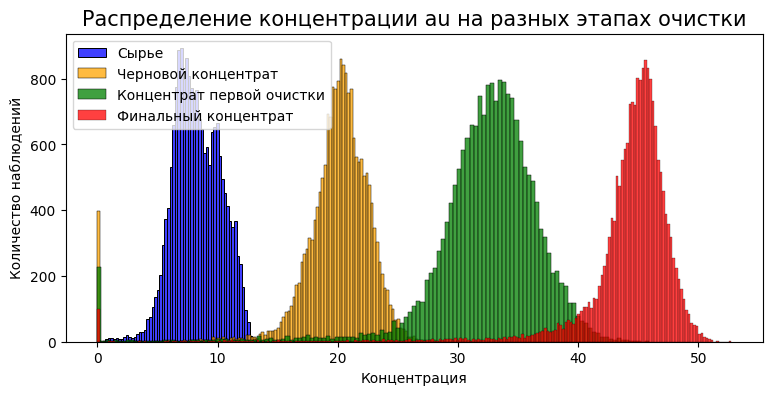

In [24]:
plot_show('au')

Динамика средней концентрации ag: 8.79 -- 11.99 -- 8.44 -- 5.17


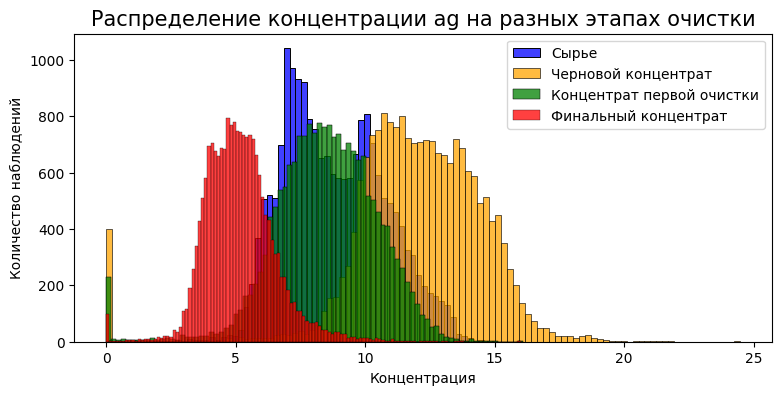

In [25]:
plot_show('ag')

Динамика средней концентрации pb: 3.60 -- 7.61 -- 9.82 -- 9.98


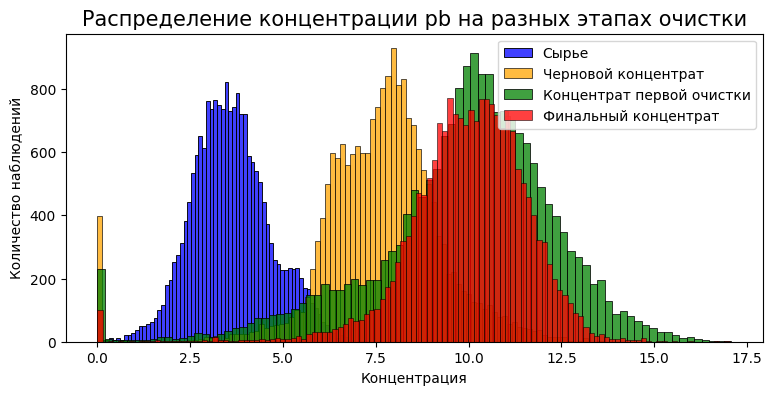

In [26]:
plot_show('pb')

Концентрация золота непрерывно увеличивается, чего не скажешь о других металлах. Наверное так и должно быть, учитывая, что цель золото.

**Сравним размеры гранул в обучающей и тестовой выборке.**

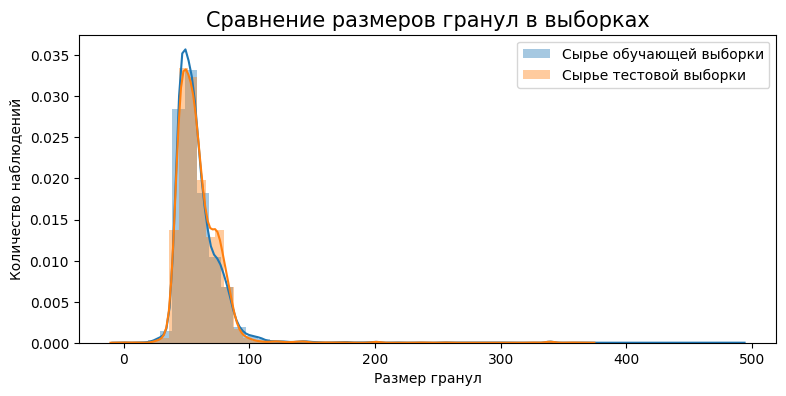

In [27]:
plt.figure(figsize=(9, 4))
sns.distplot(train['rougher.input.feed_size'].dropna(), label = "Сырье обучающей выборки")
sns.distplot(test['rougher.input.feed_size'].dropna(), label = "Сырье тестовой выборки")
plt.title(label='Сравнение размеров гранул в выборках', fontsize=15)
plt.xlabel('Размер гранул')
plt.ylabel('Количество наблюдений')
plt.legend()

Визуально размеры схожие
Сравним средние и посмотрим на стат значимость.

In [28]:
print(train['rougher.input.feed_size'].mean())
print(test['rougher.input.feed_size'].mean())

58.9703099253629
59.11339962327545


In [29]:
t_statistic, p_value = st.ttest_ind(train['rougher.input.feed_size'].dropna(), test['rougher.input.feed_size'].dropna(), equal_var=False)

print(f"Значение t-статистики: {t_statistic}")
print(f"Значение p-value: {p_value}")

Значение t-статистики: -0.45201983448853106
Значение p-value: 0.6512666877735448


Можем с уверенностью принимать нулевую гипотезу что средний размер гранул одинаковый.

**Посмотрим на общую концентрацию веществ на разных этапах очистки.**

Динамика средней общей концентрации: 57.34 -- 68.18 -- 60.87 -- 68.70


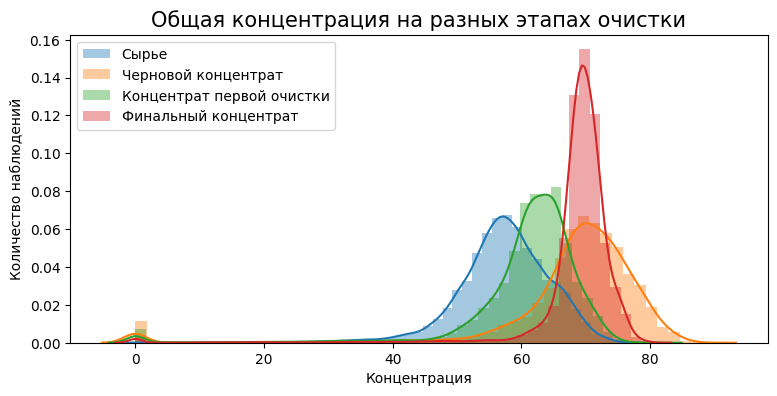

In [30]:
spisok_1 = ['au', 'ag', 'pb', 'sol']
spisok_2 = ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
for i in spisok_2:
  full[i] = full[i+spisok_1[0]] + full[i+spisok_1[1]] + full[i+spisok_1[2]] + full[i+spisok_1[3]]

с_1 = full['rougher.input.feed_']
с_2 = full['rougher.output.concentrate_']
с_3 = full['primary_cleaner.output.concentrate_']
с_4 = full['final.output.concentrate_']
plt.figure(figsize=(9, 4))
sns.distplot(с_1, label = "Сырье")
sns.distplot(с_2, label = "Черновой концентрат")
sns.distplot(с_3, label = "Концентрат первой очистки")
sns.distplot(с_4, label = "Финальный концентрат")
  
plt.title(label=f'Общая концентрация на разных этапах очистки', fontsize=15)
plt.xlabel('Концентрация')
plt.ylabel('Количество наблюдений')
plt.legend()

print(f'Динамика средней общей концентрации: {с_1.mean():.2f} -- {с_2.mean():.2f} -- {с_3.mean():.2f} -- {с_4.mean():.2f}')

Уберем выбросы из тренировочной выборки

In [31]:
to_del = full[(full['rougher.input.feed_'] < 1) | (full['rougher.output.concentrate_'] < 1) |
             (full['primary_cleaner.output.concentrate_'] < 1) | (full['final.output.concentrate_'] < 1)]

In [32]:
values_to_remove = to_del['date'].unique()
train = train[~train['date'].isin(values_to_remove)]

In [33]:
train.shape

(18722, 87)

In [34]:
train.head(7)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.47

In [35]:
count = len(train[train.isna().any(axis=1)])
print("Доля строк с пропущенными значениями:", count/len(train))

Доля строк с пропущенными значениями: 0.16595449204144858


## Модель

Подготовим данные для модели

In [36]:
only_train = list(only_train)

In [37]:
only_train.remove('rougher.output.recovery')
only_train.remove('final.output.recovery')

In [38]:
train.shape

(18722, 87)

In [39]:
train = train.drop(only_train, axis=1)

In [40]:
train.shape

(18722, 55)

In [41]:
test = pd.merge(test, full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')
train = train.drop('date', axis=1)
test = test.drop('date', axis=1)

In [42]:
col_for_filler = train.columns
filler = KNNImputer(n_neighbors=10, weights='distance')
train = pd.DataFrame(filler.fit_transform(train[col_for_filler]))
train.columns = col_for_filler
count = len(train[train.isna().any(axis=1)])
print("Доля строк с пропущенными значениями:", count/len(train))

Доля строк с пропущенными значениями: 0.0


In [43]:
col_for_filler_t = test.columns
test = pd.DataFrame(filler.fit_transform(test[col_for_filler_t]))
test.columns = col_for_filler_t
count = len(test[test.isna().any(axis=1)])
print("Доля строк с пропущенными значениями:", count/len(test))

Доля строк с пропущенными значениями: 0.0


In [44]:
print(train.shape)
print(test.shape)

(18722, 54)
(4860, 54)


In [45]:
train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
0,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,87.107763,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,70.541216
1,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,11.996163,6.012594,86.843261,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,69.266198
2,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,11.920305,6.204633,86.842308,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,68.116445
3,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835,11.692450,6.196578,87.226430,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,160

In [46]:
test.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,1147.248241,-500.363165,1047.279065,-500.354091,948.756608,-498.439416,849.441918,-499.255503,850.112246,-499.407112,6.168939,9.309852,95.248427,8.078957,6.500000,1.283045,1648.759906,-399.862053,1650.135395,-399.957321,1648.831890,-400.586116,1649.464582,-400.673303,34.940919,-500.150510,30.031867,-500.328335,26.033990,-500.147792,22.952306,-500.037678,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575,89.514960,70.281454
1,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561,6.209517,9.297194,98.880538,7.984164,6.500000,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,1651.498591,-399.745329,34.980742,-498.131002,29.968453,-586.013330,25.971737,-499.608392,22.958448,-499.821308,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,65.523246
2,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,1150.754676,-499.986009,1049.182824,-500.014696,948.085464,-499.997003,850.170086,-500.270334,849.557905,-500.198702,7.358308,9.000624,119.497545,8.003752,6.500000,1.259741,1647.368779,-399.788506,1648.395206,-400.166490,1648.953828,-400.468641,1649.821569,-400.071884,34.952967,-501.204647,29.927025,-500.106628,25.978253,-499.890060,23.004376,-500.014529,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155,91.816623,74.817644
3,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,1152.512559,-500.338106,1052.601592,-499.695075,955.171539,-500.294989,851.957342,-499.779541,850.765662,-501.030559,6.929364,8.920717,108.080163,7.970121,6.660000,0.774909,1652.660845,-399.702218,1651.203128,-40

Тренировочная и тестовая выборки готовы.

In [47]:
print(len(test[(test['rougher.output.recovery'] == 0) |
               (test['final.output.recovery'] == 0)]))

0


In [48]:
train = train[(train['rougher.output.recovery'] != 0) & (train['final.output.recovery'] != 0)]

In [49]:
features_train_r = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) 
features_test_r = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_r = train['rougher.output.recovery']
target_test_r = test['rougher.output.recovery']

features_train_f = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test_f = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_f = train['final.output.recovery']
target_test_f = test['final.output.recovery']

In [50]:
features_train_r.shape, features_test_r.shape, target_train_r.shape, target_test_r.shape,target_train_f.shape, target_test_f.shape

((18722, 52), (4860, 52), (18722,), (4860,), (18722,), (4860,))

In [51]:
features_train_r.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,1.872200e+04,18722.000000,1.872200e+04,18722.000000,1.872200e+04,18722.000000,1.872200e+04,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,1.872200e+04,18722.000000,1.872200e+04,18722.000000,1.872200e+04,18722.000000,1.872200e+04,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000,18722.000000
mean,8.272939,8.793466,3.584998,36.699324,479.345239,58.974372,12.316175,6.042207,1103.832747,-377.721884,1323.456077,-466.723259,1303.729902,-467.223312,1215.484615,-467.761368,1078.848330,-465.439726,1027.581232,-465.719347,12.064004,6.043926,145.317861,8.814963,7.309714,1.021422,1.589528e+03,-490.921084,1.591627e+03,-491.896569,1.587110e+03,-491.628748,1.541702e+03,-487.989604,28.791850,-502.050310,24.138820,-502.873258,2.823711e+01,-485.939020,2.226318e+01,-493.393403,1.898313e+01,-485.642330,1.502373e+01,-461.070582,15.719121,-488.343825,12.215966,-486.876828,19.034566,-505.242153
std,1.927726,1.925412,1.053101,5.109932,103.889954,21.875601,3.370991,1.110616,159.848888,94.224439,175.468770,54.741798,201.870799,53.594787,203.056123,53.973397,173.870158,57.485599,165.020748,57.977522,3.737835,1.138058,43.895549,3.273379,0.613037,0.511639,1.275906e+02,31.959851,1.305979e+02,33.153425,1.347368e+02,31.818895,2.476931e+02,43.135248,5.454089,53.264269,5.707156,56.339441,6.091299e+00,54.423685,5.549605e+00,43.117183,5.390349e+00,47.782913,4.875383e+00,66.438794,5.486785,34.490252,5.311784,37.969435,5.512595,37.405325
min,0.885875,1.116930,0.088552,0.463867,0.002986,0.046369,0.001147,0.000568,-0.042069,-657.949759,-0.721806,-650.065369,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-648.002444,-2.593390,-649.949283,0.000098,0.000290,0.051279,0.000000,1.080000,0.000005,5.445860e-32,-783.448551,6.647490e-32,-799.950103,

Создадим функцию расчета smape

In [52]:
def smape(predict, target):
  a = 1/len(target)*np.sum((abs(target - predict))/((abs(target + predict)/2)))*100
  return a

Теперь функцию итогового smape

In [53]:
def fin_smape(r, f):
  return 0.25*r + 0.75*f

In [54]:
smape_score = make_scorer(smape, greater_is_better=False)

Создадим и посмотрим на константную модель

In [55]:
r = smape(target_test_r.mean(), target_test_r)

In [56]:
f = smape(target_test_f.mean(), target_test_f)

In [57]:
fin_smape(r, f)

8.324184755761488

Итоговое значение smape, при расставлении средних значений - 8,32

**Линейная регрессия**

In [58]:
param_lr_grid = {'fit_intercept':[True, False], 'copy_X':[True, False]}
model_LR_r = GridSearchCV(LinearRegression(), param_grid = param_lr_grid, n_jobs=-1, cv = 5, scoring = smape_score)
model_LR_r.fit(features_train_r, target_train_r)
lr_pred_r = model_LR_r.predict(features_test_r)

In [59]:
model_LR_f = GridSearchCV(LinearRegression(), param_grid = param_lr_grid, n_jobs=-1, cv = 5, scoring = smape_score)
model_LR_f.fit(features_train_f, target_train_f)
lr_pred_f = model_LR_f.predict(features_test_f)

In [60]:
lr_r = smape(lr_pred_r, target_test_r)
print(lr_r)
lr_f = smape(lr_pred_f, target_test_f)
print(lr_f)

4.21252199056538
7.639597659987469


In [61]:
fin_smape(lr_r, lr_f)

6.782828742631947

Неплохой результат для линейной регрессии. Лучше чем константная модель.

**Дерево решений**

In [62]:
params_dtr_grid = {
    'max_depth' : range(1,11)
}
model_tree_r = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid = params_dtr_grid, cv=5, n_jobs=-1, scoring=smape_score) 
model_tree_r.fit(features_train_r, target_train_r)
tree_pred_r = model_tree_r.predict(features_test_r)

In [63]:
model_tree_f = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid = params_dtr_grid, cv=5, n_jobs=-1, scoring=smape_score) 
model_tree_f.fit(features_train_f, target_train_f)
tree_pred_f = model_tree_f.predict(features_test_f)

In [64]:
tree_r = smape(tree_pred_r, target_test_r)
print(tree_r)
tree_f = smape(tree_pred_f, target_test_f)
print(tree_f)

3.531228098840069
7.283750800705156


In [65]:
fin_smape(tree_r, tree_f)

6.345620125238884

Результат у дерева решений чуть хуже чем у линейной регрессии.

**Catboost**

In [66]:
params_catboost = {
    'iterations': [100, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 8],
    'verbose': [0]
}
model_catboost_r = GridSearchCV(
    CatBoostRegressor(random_seed=12345),
    param_grid=params_catboost,
    cv=5,
    scoring=smape_score,
    n_jobs=-1,
)
model_catboost_r.fit(features_train_r, target_train_r)
catboost_pred_r = model_catboost_r.predict(features_test_r)

In [67]:
model_catboost_f = GridSearchCV(
    CatBoostRegressor(random_seed=12345),
    param_grid=params_catboost,
    cv=5,
    scoring=smape_score,
    n_jobs=-1,
)
model_catboost_f.fit(features_train_f, target_train_f)
catboost_pred_f = model_catboost_f.predict(features_test_f)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [68]:
catboost_r = smape(catboost_pred_r, target_test_r)
print(catboost_r)
catboost_f = smape(catboost_pred_f, target_test_f)
print(catboost_f)

1.9254887158944993
4.3669597326130845


In [69]:
fin_smape(catboost_r, catboost_f)

3.756591978433438

Модель достаточно хорошо предсказывает качество финального продукта.

**Вывод:**

Для решения задачи предсказания качества продукта (золото из золотосодержащего сырья) были выполнены этапы предобработки данных, анализ данных и построение моделей и выбора лучшей.\
На этапе предобработки были осмотрены данные датасетов, определены и заполнены пропуски. При анализе данных было установлено, что концентрация золота расчет с каждым этапом очистки, чего нельзя сказать о концентрации других металлов: концентрация серебра на финальном этапе меньше концентрации в сырье. Концентрация свинца растет так же как и золота.\
Размеры гранул в тренировочной и тестовой выборке одинаковые, а значит данные пригодны для построения моделей.\
Данные были разбиты на необходимые датасеты и были построены три модели: линейная регрессия, дерево решений и градиентный бустинг. Лучшей моделью оказался градиентный бустинг. Значение smape для него было 3,76, в сравнение с 6,34 у решающего дерева и 6,78 у линейной регрессии. Модель catboost эффективно предсказывает качество продукта.